In [2]:
import os
import json
import time
#import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy.signal as signal
import h5py
import pickle
#from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import fnmatch
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

import lgdo.lh5_store as lh5
#from pygama.dsp import build_dsp
#from pygama.dsp.processors.linear_slope_fit import linear_slope_fit
#from pygama.dsp.processors.bl_subtract import bl_subtract

from multihist import Hist1d, Histdd
from datetime import datetime, timezone
from legendmeta import LegendMetadata
meta_path = '/lfs/l1/legend/users/dandrea/software/legend-metadata'
lmeta = LegendMetadata(path=meta_path)

#import pulser_analysis as pa
import analysis_utility as au

%load_ext autoreload
%autoreload 2

In [ ]:
def pulser_gain_stability(
    period,
    run,
    strings = [1],
    ene_type ='cuspEmax',
    n_file = None,
    bins = 80,
    pulser = True,
    rlim = (-0.05,0.05),
    s_file = 0
):
    sto = lh5.LH5Store()
    try:
        key_list_file = open(f'l200-{period}/{run}/l200-{period}-{run}-phy-key.list', "r")
        key_list = key_list_file.read().split('\n')
        time_string = key_list[0]
        chmap = lmeta.hardware.configuration.channelmaps.on(time_string)
    except:
        print('key list not found')
        return
    
    ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A', 'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
    ge_drift = ['V01406A', 'V01415A', 'V01387A', 'P00665C','P00748B', 'P00748A']
    ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
    ge_all = [ch for ch in ge_all if ch not in ge_off]
    ge_all = [ch for ch in ge_all if ch not in ge_drift]
    puls = [ch for ch in chmap.keys() if chmap[ch]['system']=='puls']
    
    raw_dir = f'/data2/public/prodenv/prod-orig/archive/raw-v01.00/generated/tier/raw/cal'
    raw_dir = f'{raw_dir}/{period}/{run}'
    prod_dir = '/data2/public/prodenv/prod-blind/tmp/auto'
    dsp_dir = f'{prod_dir}/generated/tier/dsp/phy/{period}/{run}'
    hit_dir = f'{prod_dir}/generated/tier/hit/phy/{period}/{run}'
    """par_dsp_dir = f'{prod_dir}/generated/par/dsp/cal/{period}/{run}'
    par_hit_dir = f'{prod_dir}/generated/par/dsp/cal/{period}/{run}'
    for file_name in os.listdir(par_dsp_dir):
        if fnmatch.fnmatch(file_name, f'*par_dsp.json'):
            par_dsp = f'{par_dsp_dir}/{file_name}'
            print('par_dsp',par_dsp)"""
    
    raw_list, dsp_list, hit_list = [], [], []
    for i, key in enumerate(key_list):
        if (n_file is not None) and (i > n_file): break
        if i < s_file: continue
        raw_list.append(f'{raw_dir}/l200-{period}-{run}-phy-{key}-tier_raw.lh5')
        dsp_list.append(f'{dsp_dir}/l200-{period}-{run}-phy-{key}-tier_dsp.lh5')
        hit_list.append(f'{hit_dir}/l200-{period}-{run}-phy-{key}-tier_hit.lh5')
    
    rspace = np.linspace(rlim[0]*5,rlim[1]*5,bins*5)
    corr = np.zeros(len(ge_all))
    nchn = 0
    #fig1, axis1 = plt.subplots(nrows=4, ncols=3,figsize=(40,40), facecolor='white')
    #fig2, axis2 = plt.subplots(nrows=4, ncols=3,figsize=(40,40), facecolor='white')
    for string in strings:
        fig1, ax1 = plt.subplots(figsize=(12,6.75), facecolor='white')
        fig2, ax2 = plt.subplots(figsize=(12,6.75), facecolor='white')
        #ax1 = axis1.flat[string-1]
        #ax2 = axis2.flat[string-1]
        ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_keys = [ch for ch in ge_keys if ch not in ge_off]
        ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
        pulser_plot = True
        for ge_key in ge_keys:
            if ge_key == 'B00089D': continue
            perc = np.zeros((2,bins-1))
            perc_au = np.zeros((2,bins-1))
            
            for ii, det_name in enumerate([puls[1],ge_key]):
                fcid = int(chmap[det_name]['daq']['rawid'])
                chn = f'ch{fcid:03}'
                
                times = sto.read_object(f"{chn}/dsp/timestamp", dsp_list)[0]
                energies = sto.read_object(f"{chn}/dsp/{ene_type}", dsp_list)[0]
                baselines = sto.read_object(f"{chn}/dsp/baseline", dsp_list)[0]
                trapTmax = sto.read_object(f"ch1027201/dsp/trapTmax", dsp_list)[0]
                times, energies, baselines, trapTmax = times.nda, energies.nda, baselines.nda, trapTmax.nda
                """try:
                    m_cal = hit_par[chn]['operations']['cuspEmax_ctc_cal']['parameters']['a']
                    q_cal = hit_par[chn]['operations']['cuspEmax_ctc_cal']['parameters']['b']
                    energies = m_cal * energies + q_cal
                    yunit = 'keV'
                except:"""
                
                if pulser:
                    mask = (trapTmax>100)
                    energies = energies[mask]
                    times = times[mask]
                else:
                    energies = energies[trapTmax<100]
                    times = times[trapTmax<100]
        
                time_space = np.linspace(times.min(),times.max(),bins)
                dt = [datetime.fromtimestamp(ts) for ts in times]
                date_space = [datetime.fromtimestamp(ts) for ts in time_space]
                dspace = [datetime.fromtimestamp(ts) for ts in np.linspace(times.min(),times.max(),20)]
        
                xticks = [mdates.date2num(x) for x in dspace]
                xticklabels = [x.strftime('%Y/%m/%d %H:%M') for x in dspace]
        
                # relative shift
                ene_mean = np.mean(energies)
                ene_rel = (energies-ene_mean)/ene_mean*1e6
                #print('mean',energies.mean())
                #ph = Histdd(dt, ene_rel, bins=(dspace, rspace))
                ph_ = Histdd(times, ene_rel, bins=(time_space, rspace))

                #ph.plot(log_scale=True,cmap='viridis',colorbar=False)
                perc50 = ph_.percentile(percentile=50, axis=1)
                perc50_av = au.moving_average(perc50,w=5)
                mean_perc = np.mean(perc50_av[:int(bins/10)])
                perc50_av -= mean_perc
                
                plt.sca(ax1)
                #ax1.plot(date_space[1:], perc50, c=base_colors[ii],ls='',marker='o',alpha=0.5)
                if det_name == 'PULS01ANA':
                    perc50_puls = perc50_av
                    if pulser_plot:
                        ax1.plot(date_space[1:], perc50_puls, c='b',ls='-',lw=2,label=f'{det_name}')
                        pulser_plot = False
                else:
                    perc50_ge = perc50_av
                    #ax1.plot(date_space[1:], perc50_av,ls='--',lw=2,label=f'{det_name}')
                perc[ii] = perc50_av
                perc_au[ii] = perc[ii]/perc[ii].max()
            corr[nchn] = np.sum([perc[0][i]*perc[1][i] for i in range(bins-1)])
            corr[nchn] /= np.sqrt(np.sum(perc[0]*perc[0])*np.sum(perc[1]*perc[1]))
            print(ge_key,'string',string,f'correlation = {corr[nchn]} %',date_space[0],'->',date_space[-1])
            ax1.plot(date_space[1:], perc50_ge, ls='-',lw=1,label=f'{det_name} - corr = {corr[nchn]*100:.2f}%')
            perc50_ge -= perc50_puls
            ax2.plot(date_space[1:], perc50_ge, ls='-',lw=1,label=f'{det_name} - corr = {corr[nchn]*100:.2f}%')
            nchn += 1
        ax1.axhline(0,c='k',ls=':')
        ax1.set_ylim(rlim[0],rlim[1])
        ax1.set_ylabel('energy shift [ppm]')
        plt.xticks(rotation=30)
        ax1.set_xticks(xticks)
        ax1.set_xticklabels(xticklabels)
        ax1.legend(title=f'string {string}')#loc='upper right')
        plt.sca(ax2)
        ax2.axhline(0,c='k',ls=':')
        ax2.set_ylim(rlim[0],rlim[1])
        ax2.set_ylabel('energy shift [ppm]')
        plt.xticks(rotation=30)
        ax2.set_xticks(xticks)
        ax2.set_xticklabels(xticklabels)
        ax2.legend(title=f'string {string}')#loc='upper right')
        fig1.savefig(f'l200-{period}/pulser_stability/l200-{period}-{run}_stability_string{string}.pdf',dpi=300, bbox_inches='tight')
        fig2.savefig(f'l200-{period}/pulser_stability/l200-{period}-{run}_stability_rem_string{string}.pdf',dpi=300, bbox_inches='tight')
    return corr, perc_au

In [ ]:
corr, pulser = pulser_gain_stability('p06', 'r002', strings=[1,2,3], s_file=80, n_file=110, rlim = (-1500,1500))

In [22]:
def baseline_stability(
    period,
    run,
    det,
    strings = [1],
    ene_type ='cuspEmax',
    n_file = None,
    bins = 80,
    pulser = True,
    rlim = (-0.05,0.05),
    blim = (14000,17000),
    s_file = 0
):
    sto = lh5.LH5Store()
    try:
        key_list_file = open(f'l200-{period}/{run}/l200-{period}-{run}-phy-key.list', "r")
        key_list = key_list_file.read().split('\n')
        time_string = key_list[0]
        chmap = lmeta.hardware.configuration.channelmaps.on(time_string)
    except:
        print('key list not found')
        return
    raw_dir = f'/lfs/l1/legend/data/public/prodenv/prod-orig/archive/raw-v01.00/generated/tier/raw/cal'
    raw_dir = f'{raw_dir}/{period}/{run}'
    prod_dir = '/lfs/l1/legend/data/public/prodenv/prod-blind/tmp/auto'
    dsp_dir = f'{prod_dir}/generated/tier/dsp/phy/{period}/{run}'
    hit_dir = f'{prod_dir}/generated/tier/hit/phy/{period}/{run}'
    raw_list, dsp_list, hit_list = [], [], []
    for i, key in enumerate(key_list):
        if (n_file is not None) and (i > n_file): break
        if i < s_file: continue
        raw_list.append(f'{raw_dir}/l200-{period}-{run}-phy-{key}-tier_raw.lh5')
        dsp_list.append(f'{dsp_dir}/l200-{period}-{run}-phy-{key}-tier_dsp.lh5')
        hit_list.append(f'{hit_dir}/l200-{period}-{run}-phy-{key}-tier_hit.lh5')
    
    rspace = np.linspace(rlim[0]*5,rlim[1]*5,bins*5)
    bspace = np.linspace(blim[0],blim[1],bins)
    ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A', 'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
    ge_drift = ['V01406A', 'V01415A', 'V01387A', 'P00665C','P00748B']
    ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
    ge_all = [ch for ch in ge_all if ch not in ge_off]
    ge_all = [ch for ch in ge_all if ch not in ge_drift]
    
    for string in strings:
        fig1, ax1 = plt.subplots(figsize=(12,6.75), facecolor='white')
        ax2 = ax1.twinx()
        ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_keys = [ch for ch in ge_keys if ch not in ge_off]
        ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
        pulser_plot = True
        for ge_key in ge_keys:
            if ge_key != det: continue
            fcid = int(chmap[ge_key]['daq']['rawid'])
            chn = f'ch{fcid:03}'
            
            times = sto.read_object(f"{chn}/dsp/timestamp", dsp_list)[0]
            energies = sto.read_object(f"{chn}/dsp/{ene_type}", dsp_list)[0]
            baseline = sto.read_object(f"{chn}/dsp/baseline", dsp_list)[0]
            bl_mean = sto.read_object(f"{chn}/dsp/bl_mean", dsp_list)[0]
            trapTmax = sto.read_object(f"ch1027201/dsp/trapTmax", dsp_list)[0]
            times, energies, baseline, bl_mean, trapTmax = times.nda, energies.nda, baseline.nda, bl_mean.nda, trapTmax.nda
                
            if pulser:
                mask = (trapTmax>100)
                energies = energies[mask]
                times = times[mask]
                baseline = baseline[mask]
                bl_mean = bl_mean[mask]
            else:
                energies = energies[trapTmax<100]
                times = times[trapTmax<100]
                baseline = baseline[trapTmax<100]
                bl_mean = bl_mean[trapTmax<100]
        
            time_space = np.linspace(times.min(),times.max(),bins)
            dt = [datetime.fromtimestamp(ts) for ts in times]
            date_space = [datetime.fromtimestamp(ts) for ts in time_space]
            dspace = [datetime.fromtimestamp(ts) for ts in np.linspace(times.min(),times.max(),20)]

            xticks = [mdates.date2num(x) for x in dspace]
            xticklabels = [x.strftime('%Y/%m/%d %H:%M') for x in dspace]

            # relative shift
            ene_rel = (energies-energies.mean())/energies.mean()*1e6
            ph = Histdd(dt, ene_rel, bins=(dspace, rspace))
            ph_ = Histdd(times, ene_rel, bins=(time_space, rspace))
            #ph.plot(log_scale=True,cmap='viridis',colorbar=False)
            perc50 = ph_.percentile(percentile=50, axis=1)
            perc50_av = au.moving_average(perc50)
            perc50_av -= perc50_av.mean()

            # baseline
            phb = Histdd(times, baseline, bins=(time_space, bspace))
            perc50b = phb.percentile(percentile=50, axis=1)
            perc50b_av = au.moving_average(perc50b)

            # bl_mean
            phbm = Histdd(times, bl_mean, bins=(time_space, bspace))
            perc50bm = phbm.percentile(percentile=50, axis=1)
            perc50bm_av = au.moving_average(perc50bm)
            
            print(ge_key,'string',string,date_space[0],'->',date_space[-1])
            ax2.plot(date_space[1:], perc50,'r', ls='-',lw=1,label=ge_key)
            ax1.plot(date_space[1:], perc50b,'b', ls='-',lw=1,label='FC baseline')
            ax1.plot(date_space[1:], perc50bm,'g', ls='-',lw=1,label='baseline mean')
        plt.sca(ax1)
        plt.xticks(rotation=30)
        ax1.set_ylim(blim[0],blim[1])
        ax1.set_ylabel('baseline [ADC]')
        #ax1.set_xticks(xticks)
        #ax1.set_xticklabels(xticklabels)
        ax1.legend(title=f'{ge_key} - {period}-{run}')
        ax2.tick_params(axis="y", labelcolor='r')
        ax2.axhline(0,c='k',ls=':')
        ax2.set_ylim(rlim[0],rlim[1])
        ax2.set_ylabel('energy shift [ppm]',color='r')

V07647B string 1 2023-03-12 05:34:23.000017 -> 2023-03-13 04:53:43.000017


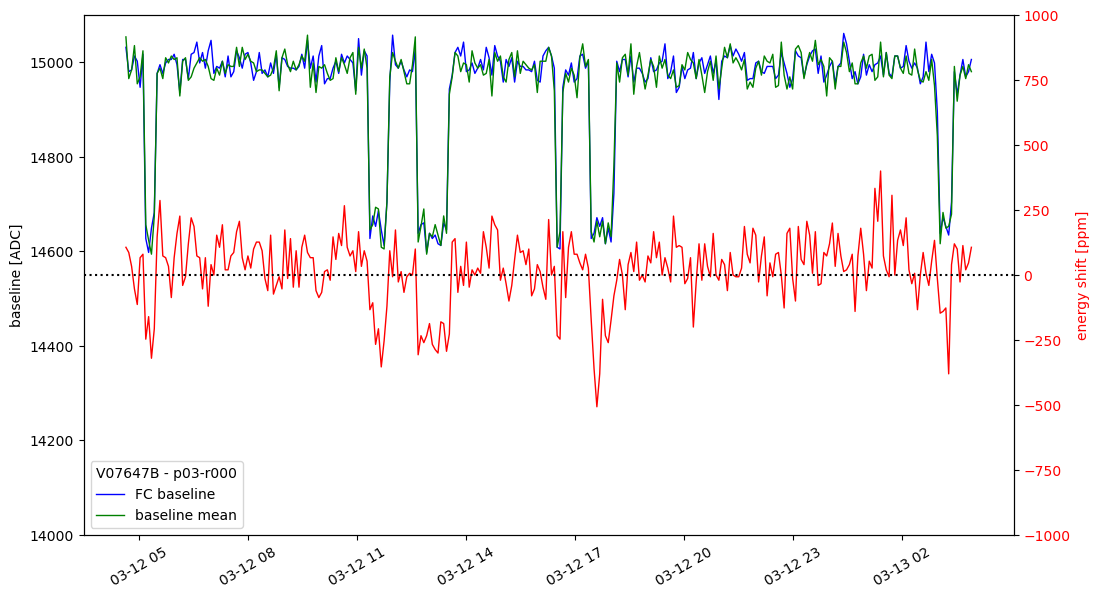

In [30]:
baseline_stability('p03', 'r000', 'V07647B',strings=[1], ene_type ='cuspEmax', n_file=25, rlim=(-1000,1000), blim=(14000,15100),bins=300)

B00035B string 10 2023-07-31 18:58:42.000017 -> 2023-08-01 21:00:44.000017


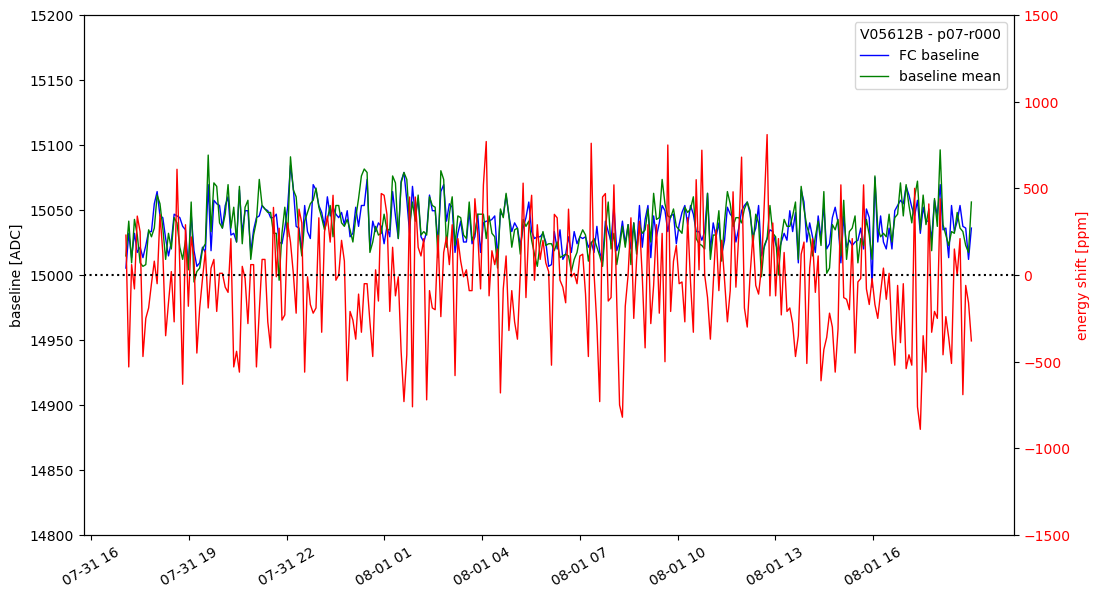

In [41]:
baseline_stability('p07','r000','B00035B', strings=[10], n_file=25, rlim=(-1500,1500), blim=(14800,15200), bins=300)